## Analyzing the Manual Coded Data


Sentiment Analysis: Analyzing the sentiment of posts helps us understand the emotional tone expressed in the text. This could be particularly useful in identifying posts that express treatments and treatment outcomes associated with mental health issues.

[Link to Mental Disorders Identification Reddit NLP dataset](https://www.kaggle.com/datasets/kamaruladha/mental-disorders-identification-reddit-nlp)

# CODE

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot  as plt

In [4]:
df1=pd.read_csv('data/sample_posts_manual_coding_2.csv')

# Looking at the manual coded data
As of 5/18 at 6:13 AM I have manually coded the first 600 entries of this csv file, which contains all posts from the BPD subreddit between 01-01-2022 and 02-01-2022. There are 1882 posts in total, so this is roughly 1/3 of the total. The CSV file is not in chronological order, however.

The column 'self' refers to whether or not the person with (diagnosed or suspected) BPD is the poster, or someone else. This is defaulted to 1, and is 0 if the post is about someone else.
The column 'is_relevant' takes an inclusive view, so includes any post which discusses therapy or medication in any way. This is defaulted to zero, and is set to 1 if the post is relevant. The majority of these mentions are only done in passing, so I created a new column called 'highly_relevant', which only includes posts which mention a specific type of therapy/medication and some type of outcome. This is defaulted to null, and set to 1 if the post is highly relevant.

From reading through 600 of these posts, here are some common patterns:
1. There are relatively few posts which go into detail about treatments. I suspect the 'is_relevant' column will not be particularly useful, but the 'highly_relevant' one might be better.
2. There may be other research questions which this data set is better suited to address, since there are a lot of commonalities between the posts.
3. A number of posts mention that other posts are getting removed or deleted. Since I have already removed those from the data (and wouldn't be able to analyze them anyway), we are getting a filtered sample.

In [4]:
print(df1.shape)

(1882, 9)


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            1882 non-null   object
 1   selftext         1882 non-null   object
 2   created_utc      1882 non-null   int64 
 3   over_18          1882 non-null   bool  
 4   subreddit        1882 non-null   object
 5   date_created     1882 non-null   object
 6   self             1882 non-null   int64 
 7   is_relevant      1882 non-null   int64 
 8   highly_relevant  21 non-null     object
dtypes: bool(1), int64(3), object(5)
memory usage: 119.6+ KB


In [6]:
## Counting the relevant posts

df1[df1['is_relevant'] != 0]['is_relevant'].count()

106

Of the first 600 posts in this sample, there are 106 relevant posts and 20 highly relevant posts (the last non-null entry is a marker for the last post which was coded).

In [5]:
posts_analyzed = 600

df_coded = df1.head(posts_analyzed)

## Removing the marker of where things were left off.

df_coded.highly_relevant[598] = np.nan

df_coded['highly_relevant'] = df_coded['highly_relevant'].fillna(0)

/var/folders/9j/j4gyltgs6txd83bg66_mv4fn664jzt/T/ipykernel_43829/1426566498.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_coded.highly_relevant[598] = np.nan
/var/folders/9j/j4gyltgs6txd83bg66_mv4fn664jzt/T/ipykernel_43829/142656649

In [8]:
distinct_entries = df_coded['highly_relevant'].unique()

# Print the distinct entries
print("Distinct entries in column 'highly_relevant':")
print(distinct_entries)

Distinct entries in column 'highly_relevant':
[0 '1']


In [9]:
## Note that the '1's are being read as strings. We'll fix that now

df_coded['highly_relevant'] = df_coded['highly_relevant'].astype(int)

/var/folders/9j/j4gyltgs6txd83bg66_mv4fn664jzt/T/ipykernel_3486/686748163.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coded['highly_relevant'] = df_coded['highly_relevant'].astype(int)


#### First attempts at building NLP models
Probably going to fail miserably, but there's only one way to find out...

In [10]:
## pip install nltk

## nltk.download('stopwords')

## nltk.download('wordnet') 

## For the life of me, I could not get this to work and had to manually download the folders and put them in the folder by hand.
## Hopefully, you have better luck with this.


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, make_scorer, accuracy_score
from sklearn.metrics import recall_score, precision_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

#### Creating a single column with all the text and removing stopwords and punctuation

In [15]:
# Combine text columns into a single column
df_coded['combined_text'] = df_coded['title'] + ' ' + df_coded['selftext']

# Punctuation removal
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

# Text preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    
    # Tokenization
    tokens = remove_punctuation(text).split()
    
    # Lowercase and remove stopwords
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing to the combined text column
df_coded['processed_text'] = df_coded['combined_text'].apply(preprocess_text)


/var/folders/9j/j4gyltgs6txd83bg66_mv4fn664jzt/T/ipykernel_3486/833915767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coded['combined_text'] = df_coded['title'] + ' ' + df_coded['selftext']
/var/folders/9j/j4gyltgs6txd83bg66_mv4fn664jzt/T/ipykernel_3486/833915767.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coded['processed_text'] = df_coded['combined_text'].apply(preprocess_text)


#### The 0th level model

In [16]:
# Split the data into a training and hold-out set
X = df_coded['processed_text']
y = df_coded['highly_relevant']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, stratify=y)

# Create a text classification pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])


## print(f"Cross-validation scores: {cv_scores}")
## print(f"Mean cross-validation score: {cv_scores.mean()}")

# Train the model on the entire training set and evaluate on the hold-out set
pipeline.fit(X_train, y_train)
y_pred_holdout = pipeline.predict(X_holdout)

print("\nEvaluation on the hold-out set:")
print(classification_report(y_holdout, y_pred_holdout))




Evaluation on the hold-out set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       116
           1       0.00      0.00      0.00         4

    accuracy                           0.97       120
   macro avg       0.48      0.50      0.49       120
weighted avg       0.93      0.97      0.95       120



/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

This is not working at all. Because the columns are so imbalanced, the model just returns 0 (not 'highly_relevant'). So let's start changing things to better reward finding 1s.

#### A slightly better baseline

In [21]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Create a text classification pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])


# Train the model on the entire training set and evaluate on the hold-out set
pipeline.fit(X_train, y_train)
y_pred_prob_holdout = pipeline.predict_proba(X_holdout)[:, 1]  # Get probabilities for the positive class



# Adjust the threshold
threshold = 0.001  # Example threshold less than 0.5 to increase sensitivity
y_pred_holdout = (y_pred_prob_holdout >= threshold).astype(int)

print("\nEvaluation on the hold-out set with adjusted threshold:")
print(classification_report(y_holdout, y_pred_holdout))


Evaluation on the hold-out set with adjusted threshold:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88       174
           1       0.10      0.67      0.18         6

    accuracy                           0.79       180
   macro avg       0.54      0.73      0.53       180
weighted avg       0.96      0.79      0.86       180



In [22]:
y_pred_prob = pipeline.predict_proba(X_train)[:, 1]  # Get probabilities for the positive class

In [23]:
# Filter the holdout set for entries predicted as positive
positive_entries = X_holdout[y_pred_holdout == 1]

# Display the positive entries from the holdout set
print("\nEntries from the holdout set that the model predicted as positive:")
print(positive_entries)

# Additionally, show the actual labels for these entries
positive_labels = y_holdout[y_pred_holdout == 1]
print("\nActual labels for the positive entries:")
print(positive_labels)


Entries from the holdout set that the model predicted as positive:
375    exactly therapy feel get therapist dont get db...
565    whats wrong posted long ago best friend bpd at...
563    rbpd monthly town hall think rbpd question com...
3      cope family doesn’t believe mental illness dia...
269    quiet bpd day like today inside organ burning ...
356    better mood swing bad im getting better managi...
90     long diagnosis take diagnosed hi i’m posting i...
47     advice overcoming future failure hey everyone ...
579    comfort title say feel creeping towards dark p...
151    i’m struggling much can’t tell anyone got prom...
117    chaos embodied borderline personality disorder...
305    don’t know much longer ran medication month ag...
336    fp snap score went it’s driving insane bffp fr...
529    like fp difference spiral negativity talk sarc...
115    i’m sick unable maintain friendship god i’m ac...
285    i’m quit job mental health bad feel guilty lik...
574    guilt crushin

There are a ton of false positives, but we seem to be doing a reasonably job of finding the relevant posts. More importantly, we can use this as a baseline to improve upon.

In [24]:
cutoffs = np.arange(0.0005,.01,.0005)

prec_scores = []
rec_scores = []

for cutoff in cutoffs:
    y_pred_holdout = (y_pred_prob_holdout >= cutoff).astype(int)
    
    prec_scores.append(precision_score(y_holdout, y_pred_holdout))
    rec_scores.append(recall_score(y_holdout, y_pred_holdout))

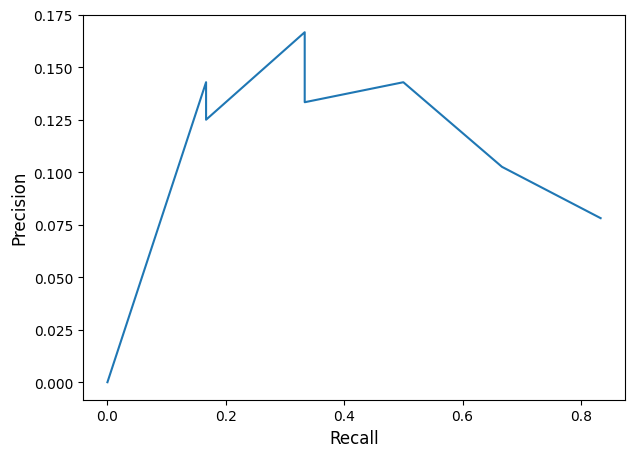

In [25]:
plt.figure(figsize=(7,5))

plt.plot(rec_scores, prec_scores)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

This is a really poor curve, but maybe with a bigger set it would be better.

This seems like a good stopping point for this model. I'm going to finish off by transferring my dataframe to a csv file so I can make use of what we've done thus far.

In [28]:
df_coded.columns

Index(['title', 'selftext', 'created_utc', 'over_18', 'subreddit',
       'date_created', 'self', 'is_relevant', 'highly_relevant',
       'combined_text', 'processed_text'],
      dtype='object')

In [30]:
specified_columns = ['created_utc', 'subreddit',
       'date_created', 'self', 'is_relevant', 'highly_relevant','processed_text','title']

new_df = pd.DataFrame(df_coded, columns=specified_columns)

new_df.to_csv('data/processed_and_coded_posts.csv', index=False)

### Trying to automatically find keywords

Before moving on, I'm going to use the baseline model to see if I can automate the process of finding keywords.

In [50]:
from sklearn.linear_model import LogisticRegression


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_coded['processed_text'])
y = df_coded['highly_relevant']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Fit the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)


# Get the feature names (keywords)
feature_names = vectorizer.get_feature_names_out()

# Get the model coefficients
coefficients = model.coef_

# Identify the strongest predictors for each category
strongest_predictors = {}

# If binary classification, we need to reshape coefficients to 2D
if coefficients.shape[0] == 1:
    coefficients = np.vstack([coefficients, -coefficients])

for i, category in enumerate(model.classes_):
    sorted_indices = np.argsort(coefficients[i])[::-1]
    strongest_keywords = [feature_names[idx] for idx in sorted_indices[:10]]  # Get top 10 keywords
    strongest_predictors[category] = strongest_keywords

# Print the strongest predictors for each category
for category, keywords in strongest_predictors.items():
    print(f"Strongest predictors for category {category}:")
    print(keywords)



Strongest predictors for category 0:
['medication', 'dbt', 'abilify', 'week', 'period', 'outpatient', 'therapist', 'harming', 'taking', 'emotion']
Strongest predictors for category 1:
['friend', 'relationship', 'fp', 'people', 'say', 'thing', 'person', 'he', 'partner', 'care']


For some reason, the predictors seem to be backwards, but I'm not sure what is going on here.

In [46]:
y_pred_prob_holdout = model.predict_proba(X_holdout)[:, 1]  # Get probabilities for the positive class



# Adjust the threshold
threshold = 0.04  # Example threshold less than 0.5 to increase sensitivity
y_pred_holdout = (y_pred_prob_holdout >= threshold).astype(int)

print("\nEvaluation on the hold-out set with adjusted threshold:")
print(classification_report(y_holdout, y_pred_holdout))


Evaluation on the hold-out set with adjusted threshold:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       116
           1       0.33      1.00      0.50         4

    accuracy                           0.93       120
   macro avg       0.67      0.97      0.73       120
weighted avg       0.98      0.93      0.95       120



This is much better than the earlier baseline model, so this will be the new baseline model. Going forward, all the models wll be contained in the model folder.

In [43]:
cutoffs = np.arange(0.01,.99,.01)

prec_scores = []
rec_scores = []

for cutoff in cutoffs:
    y_pred_holdout = (y_pred_prob_holdout >= cutoff).astype(int)
    
    prec_scores.append(precision_score(y_holdout, y_pred_holdout))
    rec_scores.append(recall_score(y_holdout, y_pred_holdout))

/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gkhan/Library/Python/3.12/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gkhan/Librar

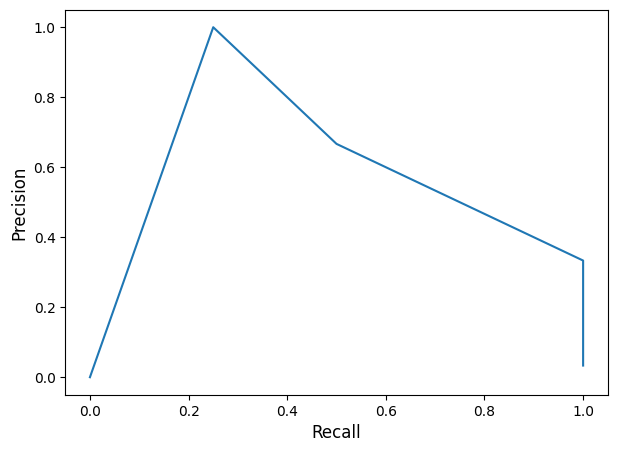

In [44]:
plt.figure(figsize=(7,5))

plt.plot(rec_scores, prec_scores)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()